# WatChMaL: Bias Analysis
### Iñaki Erregue Álvarez-Buhilla

In [1]:
import uproot
import os
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
import pandas as pd
from sklearn import metrics

In [2]:
sys.path.append('/home/ierregue/scratch/code7/')
import analysis.event_utils as ev

In [3]:
sys.path.append('/home/ierregue/scratch/code7/notebooks/utils')
from utils import *

## Load all the data

In [4]:
base_path = './data'

# TEST INDICES
idxs = np.load(base_path + '/IWCD_mPMT_Short_2_class_idxs_xps.npz', allow_pickle=True)
test_idxs  = idxs['test_idxs']

In [5]:
# METADATA

data_path = "/project/rpp-blairt2k/machine_learning/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"

h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()

towall = ev.towall(h5_positions, h5_angles)
dwall = ev.dwall(h5_positions)
momentum = ev.momentum(h5_energies, h5_labels)

In [6]:
# RESNET OUPUTS + RESNET BENCHMARK

models_base_path = ['/mcd_model/','/oc_model/']

uncertainties = np.load(base_path + models_base_path[0] + 'uncertainties.npy')[:,3] # Margin of confidence
probs = np.load(base_path + models_base_path[0] + 'softmax.npy')
pred = np.load(base_path + models_base_path[0] + 'predictions.npy')

bm_probs = np.load(base_path + models_base_path[1] + 'softmax.npy')
bm_pred = np.load(base_path + models_base_path[1] + 'predictions.npy')

In [7]:
# BUILD DF

data_matrix = np.vstack((test_idxs, h5_labels, pred, probs[:,1], bm_pred, bm_probs[:,1], uncertainties, towall, dwall, momentum, h5_energies, h5_angles[:,0], h5_angles[:,1]))
df = pd.DataFrame(data_matrix.T, columns=['id','label', 'pred', 'eprob', 'bm_pred', 'bm_eprob', 'confidence', 'towall', 'dwall', 'p', 'E', 'zen', 'azi'])
df.head()

,id,label,pred,eprob,bm_pred,bm_eprob,confidence,towall,dwall,p,E,zen,azi
0,2944634.0,0.0,0.0,0.421730,1.0,0.506945,0.156539,190.761574,64.608521,245.777585,245.777588,2.380216,-2.014716
1,2944635.0,0.0,0.0,0.101458,0.0,0.285650,0.797085,158.604782,99.009644,858.386823,858.386841,2.396345,-1.009569
2,2944636.0,0.0,0.0,0.215759,0.0,0.153855,0.568482,41.012970,30.859924,984.556023,984.556030,0.719032,-1.875060
3,2944637.0,0.0,1.0,0.761131,1.0,0.600822,0.522262,417.253355,121.900787,818.989202,818.989197,1.234110,1.671546
4,2944638.0,0.0,0.0,0.297057,0.0,0.321792,0.405886,78.351025,74.096588,60.207409,60.207409,1.387609,0.267695


## 0 - General Performance (Orginal vs. Time)

In [8]:
results = []
for mode in models_base_path:
    results.append(basic_metrics(base_path, h5_labels, mode))
    
pd.set_option("display.precision", 4)
df_perf = pd.DataFrame(results)

df_perf.sort_values(by='auc', inplace=True, ascending=False)
df_perf = df_perf[['model','log_loss', 'acc', 'f1', 'auc']].reset_index(drop=True)
df_perf


,model,log_loss,acc,f1,auc
0,/mcd_model/,0.5856,0.6864,0.6795,0.7550
1,/oc_model/,0.6271,0.6427,0.6203,0.7007


In [9]:
print(df_perf.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
      model &  log\_loss &    acc &     f1 &    auc \\
\midrule
/mcd\_model/ &    0.5856 & 0.6864 & 0.6795 & 0.7550 \\
 /oc\_model/ &    0.6271 & 0.6427 & 0.6203 & 0.7007 \\
\bottomrule
\end{tabular}



In [10]:
df[['label', 'confidence']].groupby('label').mean()

,confidence
label,
0.0,0.3702
1.0,0.3907


/tmp/ipykernel_8420/410507006.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('cms.png', dpi=300, tight_layout=True)


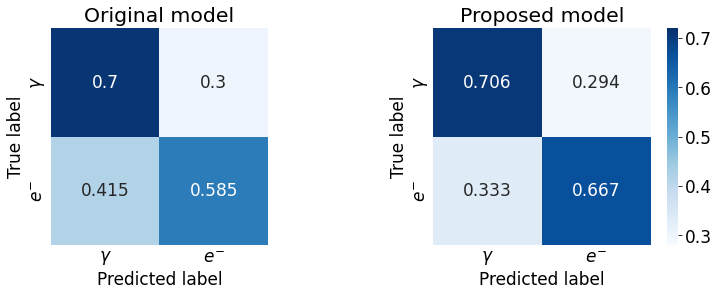

In [11]:
plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))


bm_cm = metrics.confusion_matrix(h5_labels,bm_pred,normalize='true')
sns.heatmap(bm_cm, annot=True, fmt='.3g', ax=axs[0], cmap='Blues', vmin=0.28, vmax=0.71, cbar=None, square=True, xticklabels=[r'$\gamma$', r'$e^{-}$'], yticklabels=[r'$\gamma$', r'$e^{-}$'])
axs[0].set_title('Original model')
axs[0].set_ylabel('True label')
axs[0].set_xlabel('Predicted label')
axs[0].tick_params(axis=u'both', which=u'both',length=0)



mcd_cm = metrics.confusion_matrix(h5_labels,pred,normalize='true')
sns.heatmap(mcd_cm, annot=True, fmt='.3g', ax=axs[1], cmap='Blues', vmin=0.28, vmax=0.72, square=True, xticklabels=[r'$\gamma$', r'$e^{-}$'], yticklabels=[r'$\gamma$', r'$e^{-}$'])
axs[1].set_title('Proposed model')
axs[1].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')
axs[1].tick_params(axis=u'both', which=u'both',length=0)

plt.savefig('cms.png', dpi=300, tight_layout=True)


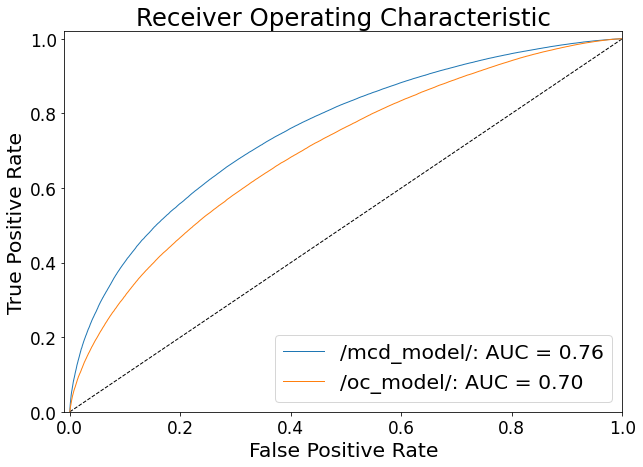

In [12]:
draw_roc_curve(base_path, h5_labels, models_base_path)

## 2 - Phase Space 

In [13]:
def electron_signal_eff(y_actual, y_hat):
    cm1 = metrics.confusion_matrix(y_actual, y_hat)
    TPR = cm1[1,1]/(cm1[1,1]+cm1[1,0])
    return TPR

In [14]:
electron_signal_eff(df['label'],df['pred'])

0.6665127428544265

### 2.1 - Energy

In [15]:
# BINS

df['E_bins'] = pd.cut(df['E'], bins=np.arange(0,1050,50), labels=np.arange(25,1025,50))

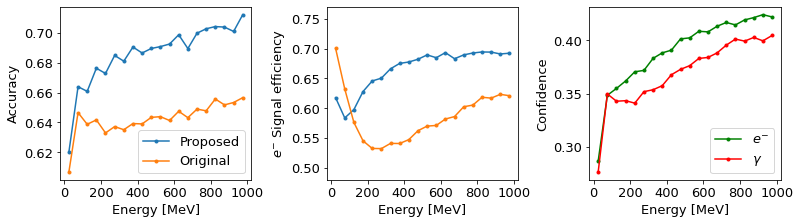

In [16]:
# Energy vs Accuracy and Signal eff
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(ncols=3, figsize=(11,3), sharex=True, constrained_layout=True)

bin_acc = df[['label','pred', 'E_bins']].groupby('E_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'E_bins']].groupby('E_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Proposed')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_bm_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
axes[0].set_xticks(np.arange(0,1200,200))
axes[0].set_xlabel('Energy [MeV]')
axes[0].set_ylabel('Accuracy')
axes[0].legend()


bin_ese = df[['label','pred', 'E_bins']].groupby('E_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'E_bins']].groupby('E_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)
axes[1].set_xticks(np.arange(0,1200,200))
axes[1].set_ylim(0.48,0.77)
axes[1].set_xlabel('Energy [MeV]')
axes[1].set_ylabel(r'$e^{-}$ Signal efficiency')


bin_uncertainty = df[['confidence', 'E_bins', 'label']].groupby(['E_bins','label']).mean().reset_index()
unc_0s = bin_uncertainty[bin_uncertainty['label']==0][['E_bins','confidence']].to_numpy()
unc_1s = bin_uncertainty[bin_uncertainty['label']==1][['E_bins','confidence']].to_numpy()

axes[2].errorbar(unc_1s[:,0], unc_1s[:,1], fmt='.-g', elinewidth=0.5, capsize=1, label=r'$e^{-}$')
axes[2].errorbar(unc_0s[:,0], unc_0s[:,1], fmt='.-r', elinewidth=0.5, capsize=1, label=r'$\gamma$')
axes[2].set_xticks(np.arange(0,1200,200))
axes[2].set_xlabel('Energy [MeV]')
axes[2].set_ylabel('Confidence')
axes[2].legend(loc=4)

plt.savefig('energies.png', dpi=300)
plt.show()

## 3 - Detector Geometry

### 3.1 - Distances

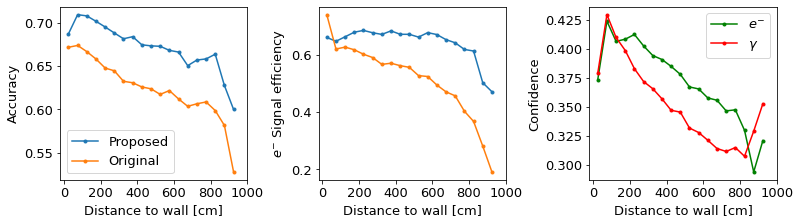

In [17]:
df['d1_bins'] = pd.cut(df['towall'], bins=np.arange(0,1000,50), labels=np.arange(25,975,50))

plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(ncols=3, figsize=(11,3), sharex=True, constrained_layout=True)

bin_acc = df[['label','pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Proposed')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_bm_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
axes[0].set_xticks(np.arange(0,1200,200))
axes[0].set_xlabel('Distance to wall [cm]')
axes[0].set_ylabel('Accuracy')
axes[0].legend()


bin_ese = df[['label','pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'd1_bins']].groupby('d1_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)
axes[1].set_xticks(np.arange(0,1200,200))
#axes[1].set_ylim(0.48,0.77)
axes[1].set_xlabel('Distance to wall [cm]')
axes[1].set_ylabel(r'$e^{-}$ Signal efficiency')


bin_uncertainty = df[['confidence', 'd1_bins', 'label']].groupby(['d1_bins','label']).mean().reset_index()
unc_0s = bin_uncertainty[bin_uncertainty['label']==0][['d1_bins','confidence']].to_numpy()
unc_1s = bin_uncertainty[bin_uncertainty['label']==1][['d1_bins','confidence']].to_numpy()

axes[2].errorbar(unc_1s[:,0], unc_1s[:,1], fmt='.-g', elinewidth=0.5, capsize=1, label=r'$e^{-}$')
axes[2].errorbar(unc_0s[:,0], unc_0s[:,1], fmt='.-r', elinewidth=0.5, capsize=1, label=r'$\gamma$')
axes[2].set_xticks(np.arange(0,1200,200))
axes[2].set_xlabel('Distance to wall [cm]')
axes[2].set_ylabel('Confidence')
axes[2].legend(loc=1)

plt.savefig('dtowall.png', dpi=300)
plt.show()

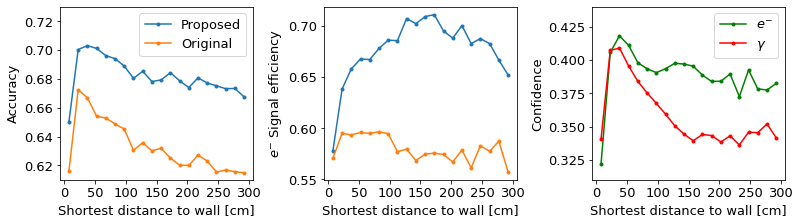

In [18]:
df['d2_bins'] = pd.cut(df['dwall'], bins=np.arange(0,315,15), labels=np.arange(7.5,307.5,15))

plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(ncols=3, figsize=(11,3), sharex=True, constrained_layout=True)

bin_acc = df[['label','pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Proposed')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_bm_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
axes[0].set_xticks(np.arange(0,350,50))
axes[0].set_ylim(0.61,0.73)
axes[0].set_xlabel('Shortest distance to wall [cm]')
axes[0].set_ylabel('Accuracy')
axes[0].legend()


bin_ese = df[['label','pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'd2_bins']].groupby('d2_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)
axes[1].set_xticks(np.arange(0,350,50))
axes[1].set_xlabel('Shortest distance to wall [cm]')
axes[1].set_ylabel(r'$e^{-}$ Signal efficiency')


bin_uncertainty = df[['confidence', 'd2_bins', 'label']].groupby(['d2_bins','label']).mean().reset_index()
unc_0s = bin_uncertainty[bin_uncertainty['label']==0][['d2_bins','confidence']].to_numpy()
unc_1s = bin_uncertainty[bin_uncertainty['label']==1][['d2_bins','confidence']].to_numpy()

axes[2].errorbar(unc_1s[:,0], unc_1s[:,1], fmt='.-g', elinewidth=0.5, capsize=1, label=r'$e^{-}$')
axes[2].errorbar(unc_0s[:,0], unc_0s[:,1], fmt='.-r', elinewidth=0.5, capsize=1, label=r'$\gamma$')
axes[2].set_xticks(np.arange(0,350,50))
axes[2].set_ylim(0.31,0.44)
axes[2].set_xlabel('Shortest distance to wall [cm]')
axes[2].set_ylabel('Confidence')
axes[2].legend(loc=1)

plt.savefig('sdwall.png', dpi=300)
plt.show()

### 3.2 - Angles

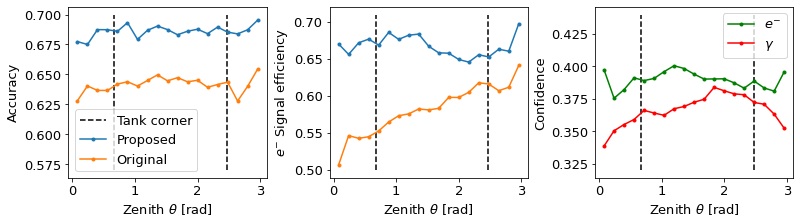

In [19]:
df['zen_bins'] = pd.cut(df['zen'], bins=np.arange(0,3.2,0.16), labels=np.arange(0.08,3.12,0.16))

# Energy vs Accuracy and Signal eff
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(ncols=3, figsize=(11,3), sharex=True, constrained_layout=True)

bin_acc = df[['label','pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Proposed')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_bm_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
axes[0].set_xlabel(r'Zenith $\theta$ [rad]')
axes[0].vlines(0.67, ymin=0.57, ymax=0.7, label='Tank corner', linestyle='--', colors='black')
axes[0].vlines(2.47, ymin=0.57, ymax=0.7, linestyle='--', colors='black')
axes[0].set_ylabel('Accuracy')
axes[0].legend()


bin_ese = df[['label','pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'zen_bins']].groupby('zen_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)
axes[1].set_xlabel(r'Zenith $\theta$ [rad]')
axes[1].vlines(0.67, ymin=0.5, ymax=0.71, label='Tank corner', linestyle='--', colors='black')
axes[1].vlines(2.47, ymin=0.5, ymax=0.71, linestyle='--', colors='black')
axes[1].set_ylabel(r'$e^{-}$ Signal efficiency')


bin_uncertainty = df[['confidence', 'zen_bins', 'label']].groupby(['zen_bins','label']).mean().reset_index()
unc_0s = bin_uncertainty[bin_uncertainty['label']==0][['zen_bins','confidence']].to_numpy()
unc_1s = bin_uncertainty[bin_uncertainty['label']==1][['zen_bins','confidence']].to_numpy()

axes[2].errorbar(unc_1s[:,0], unc_1s[:,1], fmt='.-g', elinewidth=0.5, capsize=1, label=r'$e^{-}$')
axes[2].errorbar(unc_0s[:,0], unc_0s[:,1], fmt='.-r', elinewidth=0.5, capsize=1, label=r'$\gamma$')
axes[2].set_xlabel(r'Zenith $\theta$ [rad]')
axes[2].vlines(0.67, ymin=0.32, ymax=0.44, linestyle='--', colors='black')
axes[2].vlines(2.47, ymin=0.32, ymax=0.44, linestyle='--', colors='black')
axes[2].set_ylabel('Confidence')
axes[2].legend(loc=1)

plt.savefig('zen.png', dpi=300)
plt.show()

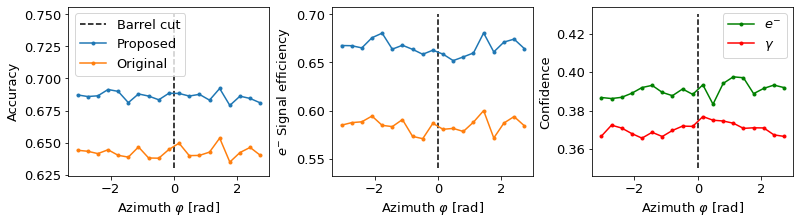

In [20]:
df['azi_bins'] = pd.cut(df['azi'], bins=np.arange(-3.2,3.2,0.32), labels=np.arange(-3.04,3.04,0.32))

# Energy vs Accuracy and Signal eff
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(ncols=3, figsize=(11,3), sharex=True, constrained_layout=True)

bin_acc = df[['label','pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_acc = df[['label','bm_pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: metrics.accuracy_score (x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[0].errorbar(bin_acc[:,0], bin_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Proposed')#yerr=bin_uncertainty[:,1]
axes[0].errorbar(bin_bm_acc[:,0], bin_bm_acc[:,1], fmt='.-', elinewidth=0.5, capsize=1, label='Original')
axes[0].set_xlabel(r'Azimuth $\varphi$ [rad]')
axes[0].vlines(0, ymin=0.63, ymax=0.75, label='Barrel cut', linestyle='--', colors='black')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc=2)


bin_ese = df[['label','pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: electron_signal_eff(x['label'],x['pred'])).reset_index().to_numpy()
bin_bm_ese = df[['label','bm_pred', 'azi_bins']].groupby('azi_bins').apply(lambda x: electron_signal_eff(x['label'],x['bm_pred'])).reset_index().to_numpy()

axes[1].errorbar(bin_ese[:,0], bin_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)#yerr=bin_uncertainty[:,1]
axes[1].errorbar(bin_bm_ese[:,0], bin_bm_ese[:,1], fmt='.-', elinewidth=0.5, capsize=1)
axes[1].set_xlabel(r'Azimuth $\varphi$ [rad]')
axes[1].vlines(0, ymin=0.54, ymax=0.7, label='Barrel cut', linestyle='--', colors='black')
axes[1].set_ylabel(r'$e^{-}$ Signal efficiency')


bin_uncertainty = df[['confidence', 'azi_bins', 'label']].groupby(['azi_bins','label']).mean().reset_index()
unc_0s = bin_uncertainty[bin_uncertainty['label']==0][['azi_bins','confidence']].to_numpy()
unc_1s = bin_uncertainty[bin_uncertainty['label']==1][['azi_bins','confidence']].to_numpy()

axes[2].errorbar(unc_1s[:,0], unc_1s[:,1], fmt='.-g', elinewidth=0.5, capsize=1, label=r'$e^{-}$')
axes[2].errorbar(unc_0s[:,0], unc_0s[:,1], fmt='.-r', elinewidth=0.5, capsize=1, label=r'$\gamma$')
axes[2].set_xlabel(r'Azimuth $\varphi$ [rad]')
axes[2].vlines(0, ymin=0.35, ymax=0.43, linestyle='--', colors='black')
axes[2].set_ylabel('Confidence')
axes[2].legend(loc=1)

plt.savefig('azi.png', dpi=300)
plt.show()